# Fake News Detection using Machine Learning on the WELFake Dataset

## Introduction

In today's digital age, the proliferation of fake news has become a significant concern. The ability to automatically detect and classify news articles as real or fake is crucial for maintaining the integrity of information. This project aims to develop a machine learning model that can accurately classify news articles using the WELFake dataset. This notebook documents the entire process, from data loading and preprocessing to model training, evaluation, and deployment.

---

## Table of Contents

1. [Importing Libraries](#importing-libraries)
2. [Loading and Exploring the Data](#loading-and-exploring-the-data)
   - [Dataset Description](#dataset-description)
   - [Initial Data Inspection](#initial-data-inspection)
3. [Data Preprocessing](#data-preprocessing)
   - [Handling Missing Values](#handling-missing-values)
   - [Exploratory Data Analysis](#exploratory-data-analysis)
     - [Text Length Analysis](#text-length-analysis)
   - [Text Cleaning](#text-cleaning)
     - [Tokenization, Stopword Removal, and Stemming](#text-cleaning-steps)
4. [Feature Extraction](#feature-extraction)
   - [TF-IDF Vectorization](#tf-idf-vectorization)
5. [Model Training](#model-training)
   - [Train-Test Split](#train-test-split)
   - [Multinomial Naive Bayes Classifier](#multinomial-naive-bayes-classifier)
   - [Random Forest Classifier](#random-forest-classifier)
6. [Model Evaluation](#model-evaluation)
   - [Classification Reports](#classification-reports)
7. [Model Saving and Deployment](#model-saving-and-deployment)
   - [Saving Models with Pickle](#saving-models-with-pickle)
   - [Loading Models for Prediction](#loading-models-for-prediction)
8. [Prediction on New Data](#prediction-on-new-data)
9. [Challenges and Solutions](#challenges-and-solutions)
10. [Conclusion](#conclusion)
11. [Future Work](#future-work)
12. [References](#references)

---


## 1. Importing Libraries <a name="importing-libraries"></a>

*We begin by importing all the necessary libraries required for data manipulation, visualization, preprocessing, and model building.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from pickle import dump
#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')

## 2. Loading and Exploring the Data <a name="loading-and-exploring-the-data"></a>

### Dataset Description <a name="dataset-description"></a>

*The WELFake dataset is a comprehensive collection of news articles, merged from four popular datasets (Kaggle, McIntire, Reuters, BuzzFeed Political) to prevent overfitting and provide ample text data for machine learning training.*

- **Total Entries:** 72,134 news articles
  - **Real News:** 35,028 articles (Label = 1)
  - **Fake News:** 37,106 articles (Label = 0)
- **Columns:**
  - `Serial number`: Unique identifier for each article
  - `Title`: Headline of the news article
  - `Text`: Main content of the news article
  - `Label`: Indicates whether the news is real (1) or fake (0)

### Initial Data Inspection <a name="initial-data-inspection"></a>

*We load the dataset and perform initial inspections to understand its structure and identify any immediate issues.*


In [2]:
#load Data
data = pd.read_csv("WELFake_Dataset.csv")

print(data.head())

   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  


## 3. Data Preprocessing <a name="data-preprocessing"></a>

### Handling Missing Values <a name="handling-missing-values"></a>

*We check for missing values and handle them appropriately to ensure data integrity.*

In [3]:
data.drop(columns='Unnamed: 0',inplace=True)

print(data.shape)

print(data.isnull().sum())

data.fillna(' ',inplace=True)
print(data.isnull().sum())

(72134, 3)
title    558
text      39
label      0
dtype: int64
title    0
text     0
label    0
dtype: int64


### Exploratory Data Analysis <a name="exploratory-data-analysis"></a>

#### Text Length Analysis <a name="text-length-analysis"></a>

*We analyze the distribution of text lengths to understand differences between fake and real news articles.*

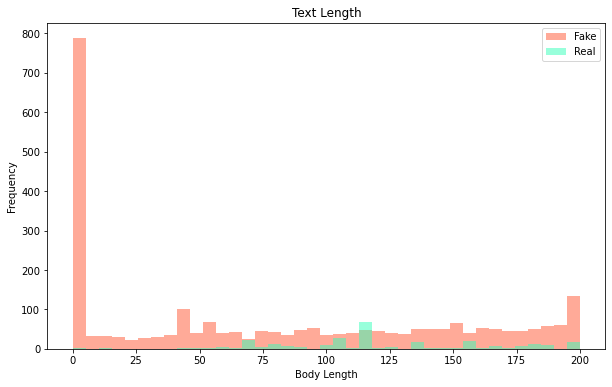

In [4]:
data['body_len'] = data['text'].apply(len)

bins = np.linspace(0, 200, 40)
plt.figure(figsize=(10, 6))
plt.hist(data[data["label"]== 1]["body_len"], bins, alpha=0.5, label="Fake", color="#FF5733")
plt.hist(data[data["label"]== 0]["body_len"], bins, alpha=0.5, label="Real", color="#33FFB8")
plt.legend(loc="upper left")
plt.xlabel('Body Length')
plt.ylabel('Frequency')
plt.title('Text Length')
plt.legend(loc='upper right')
plt.show()

### Text Cleaning <a name="text-cleaning"></a>

*We define a function to clean the text data, which includes several preprocessing steps to prepare the data for vectorization.*

#### Tokenization, Stopword Removal, and Stemming <a name="text-cleaning-steps"></a>

In [5]:
ps = PorterStemmer()
def clean_text(txt):
        txt = txt.lower()
        txt = word_tokenize(txt)
        txt = [t for t in txt if t not in punctuation]
        txt = [t for t in txt if t not in stopwords.words("english")]
        txt = [ps.stem(t)for t in txt]
        txt = " ".join(txt)
        return txt
 

data.loc[:,"clean_text"]=data["text"].apply(clean_text)
print(data.head())

                                               title  \
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1                                                      
2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3  Bobby Jindal, raised Hindu, uses story of Chri...   
4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  body_len  \
0  No comment is expected from Barack Obama Membe...      1      5049   
1     Did they post their votes for Hillary already?      1        46   
2   Now, most of the demonstrators gathered last ...      1       216   
3  A dozen politically active pastors came here f...      0      8010   
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1      1916   

                                          clean_text  
0  comment expect barack obama member fyf911 fuky...  
1                          post vote hillari alreadi  
2  demonstr gather last night exercis constitut p...  
3  d

## 4. Feature Extraction <a name="feature-extraction"></a>

### TF-IDF Vectorization <a name="tf-idf-vectorization"></a>

*We transform the cleaned text data into numerical features using TF-IDF vectorization, which considers both term frequency and inverse document frequency.*


In [7]:
cv = TfidfVectorizer()
vector = cv.fit_transform(data["clean_text"])

In [8]:
print(vector.shape)

(72134, 211778)


In [9]:
features = pd.DataFrame.sparse.from_spmatrix(vector,columns=cv.get_feature_names_out())
target = data['label']

In [26]:
print(features.head())

         00       000  0000  000000031  00000017  00000031  000035  00004  \
0  0.034446  0.000000   0.0        0.0       0.0       0.0     0.0    0.0   
1  0.000000  0.000000   0.0        0.0       0.0       0.0     0.0    0.0   
2  0.000000  0.000000   0.0        0.0       0.0       0.0     0.0    0.0   
3  0.000000  0.011335   0.0        0.0       0.0       0.0     0.0    0.0   
4  0.000000  0.078388   0.0        0.0       0.0       0.0     0.0    0.0   

   000048  00006  ...  集体安全条约组织  集体安全条约组织与联合国专门机构  集体安全条约组织是多层面结构  \
0     0.0    0.0  ...       0.0               0.0             0.0   
1     0.0    0.0  ...       0.0               0.0             0.0   
2     0.0    0.0  ...       0.0               0.0             0.0   
3     0.0    0.0  ...       0.0               0.0             0.0   
4     0.0    0.0  ...       0.0               0.0             0.0   

   集体安全条约组织正在积极促进帮助阿富汗进行冲突后重建以及消除来自该国的毒品威胁的国际努力  集体安全条约组织秘书长博尔久扎  集体提出创新办法  \
0                                           

## 5. Model Training <a name="model-training"></a>

### Train-Test Split <a name="train-test-split"></a>

*We split the dataset into training and testing sets to evaluate the model's performance on unseen data.*

In [13]:
x_train,x_test,y_train,y_test = train_test_split(features,target)

### Multinomial Naive Bayes Classifier <a name="multinomial-naive-bayes-classifier"></a>

*We train a Multinomial Naive Bayes classifier, which is suitable for text classification tasks.*

In [14]:
mnb=MultinomialNB()
mnb.fit(x_train,y_train)

MultinomialNB()

### Random Forest Classifier <a name="random-forest-classifier"></a>

*We train a Random Forest classifier with 300 estimators to improve prediction accuracy.*


In [15]:
rf = RandomForestClassifier(n_estimators=300)
rf.fit(x_train,y_train)

RandomForestClassifier(n_estimators=300)

## 6. Model Evaluation <a name="model-evaluation"></a>

### Classification Reports <a name="classification-reports"></a>

*We evaluate both models using classification reports to compare their performance.*


In [21]:
crnb = classification_report(y_test,mnb.predict(x_test))
crf = classification_report(y_test,rf.predict(x_test))
print("MultinomialNB =",crnb,"RandomForestClassifier =",crf)

MultinomialNB =               precision    recall  f1-score   support

           0       0.88      0.88      0.88      8831
           1       0.89      0.89      0.89      9203

    accuracy                           0.88     18034
   macro avg       0.88      0.88      0.88     18034
weighted avg       0.88      0.88      0.88     18034
 RandomForestClassifier =               precision    recall  f1-score   support

           0       0.96      0.93      0.94      8831
           1       0.93      0.96      0.95      9203

    accuracy                           0.94     18034
   macro avg       0.95      0.94      0.94     18034
weighted avg       0.95      0.94      0.94     18034



## 7. Model Saving and Deployment <a name="model-saving-and-deployment"></a>

### Saving Models with Pickle <a name="saving-models-with-pickle"></a>

*We save the trained models and vectorizer using the pickle module for future use without retraining.*


In [11]:
f= open("CV_FRN.pkl","wb")
dump(cv,f)
f.close()

In [18]:
# vector creation
f= open("CV_FRN.pkl","wb")
dump(cv,f)
f.close()

# MultinomialNB model creation
f= open("MNB_FRN.pkl","wb")
dump(mnb,f)
f.close()

# RandomForestClassifier model creation
f= open("RF_FRN.pkl","wb")
dump(rf,f)
f.close()



### Loading Models for Prediction <a name="loading-models-for-prediction"></a>

*We demonstrate how to load the saved models and vectorizer to make predictions on new data.*


In [19]:
# laod in vector file for prediction
from pickle import load

f=open("CV_FRN.pkl","rb")
cv=load(f)
f.close()

f=open("MNB_FRN.pkl","rb")
mnb=load(f)
f.close()

f=open("RF_FRN.pkl","rb")
rf=load(f)
f.close()


## 8. Prediction on New Data <a name="prediction-on-new-data"></a>

*We accept user input, preprocess it, and use both models to predict whether the news is fake or real.*

In [24]:
# Prediction 

news = input("enter news text ") 

# Cleaned user input data
cnews=clean_text(news)

# vectorize cleaned data
vnews=cv.transform([cnews])

# predict using both Model
#MultinomialNB model
pred_mnb=mnb.predict(vnews)

#RandomForestClassifier model
pred_rf=rf.predict(vnews)

print("MultinomialNB =",pred_mnb[0],"RandomForestClassifier =",pred_rf[0])

enter news text GENEVA (Reuters) - The United Nations called on Monday for a humanitarian pause in the Yemeni capital of Sanaa on Tuesday to allow civilians to leave their homes, aid workers to reach them, and the wounded to get medical care. Jamie McGoldrick, U.N. humanitarian coordinator in Yemen, said in a statement that the streets of Sanaa had become  battlegrounds  and that aid workers  remain in lockdown .  Thus, I call on all parties to the conflict to urgently enable a humanitarian pause on Tuesday 5 December, between 10:00 a.m. and 16:00 p.m. to allow civilians to leave their homes and seek assistance and protection and to facilitate the movement of aid workers to ensure the continuity of life-saving programs,  he said.  McGoldrick warned the warring parties that any deliberate attacks against civilians, and against civilian and medical infrastructure, are  clear violations of international humanitarian law and may constitute war crimes . 
MultinomialNB = 0 RandomForestClassi

## 9. Challenges and Solutions <a name="challenges-and-solutions"></a>

*During the project, we faced several challenges due to the large size of the dataset and high dimensionality of the feature space.*

- **Memory Limitations:**
  - **Issue:** Memory errors occurred when processing n-grams and bigrams with `CountVectorizer`, resulting in over 600,000 features.
  - **Solution:** Switched to `TfidfVectorizer` and used a sparse matrix representation to handle the large feature set efficiently.

- **Processing Time:**
  - **Issue:** Data splitting and model training were time-consuming, with some steps taking several hours.
  - **Solution:** Opted for more efficient algorithms and limited the use of resource-intensive processes.

- **Data Preprocessing Decisions:**
  - **Issue:** Including stopwords led to increased dimensionality and memory issues.
  - **Solution:** Removed stopwords to reduce the feature space and avoid memory constraints.

---

## 10. Conclusion <a name="conclusion"></a>

*By carefully preprocessing the data and selecting appropriate models, we successfully built classifiers capable of distinguishing between fake and real news with high accuracy. The Random Forest Classifier performed better, achieving approximately 94% accuracy compared to 91% with Multinomial Naive Bayes. Despite challenges related to memory and processing time, the project demonstrates the effectiveness of machine learning in text classification tasks.*


---

## 12. References <a name="references"></a>

- WELFake Dataset Publication: [IEEE Transactions on Computational Social Systems](https://doi.org/10.1109/TCSS.2021.3068519)
- NLTK Documentation: [NLTK 3.6.2](https://www.nltk.org/)
- Scikit-learn Documentation: [scikit-learn](https://scikit-learn.org/stable/)
- Python Pickle Module: [pickle — Python object serialization](https://docs.python.org/3/library/pickle.html)

---
